In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

class ForecastGrapper:
    def __init__(self, url="https://kursprognose.com/", company="nvidia"):
        self.url = url
        self.company = company
        self._update_full_url()
        self.daily_forecast = None
        self.monthly_forecast = None
        self.combined_df = None  # Added property to store the combined DataFrame

    def _update_full_url(self):
        self.full_url = f"{self.url}{self.company}"
    
    def set_company(self, company: str):
        self.company = company
        self._update_full_url()
    
    def grap_forecast(self):
        tables = pd.read_html(self.full_url)
        
        if len(tables) >= 2:
            self.daily_forecast = tables[0]
            self.monthly_forecast = tables[1]
        else:
            raise ValueError("Not enough tables found on the webpage.")
    
    def save_forecast(self):
        if self.daily_forecast is None or self.monthly_forecast is None:
            raise ValueError("Forecast data not available. Run grap_forecast() first.")
        
        # remove year rows from monthly forecast & rmove the first row (label) from both
        mask = pd.to_numeric(self.monthly_forecast[0], errors='coerce').isna()
        monthly_forecast_filtered = self.monthly_forecast[mask]
        monthly_forecast_filtered = monthly_forecast_filtered.iloc[1+2:] # remove first two month as they are included in daily forecast
        daily_forecast_filtered = self.daily_forecast.iloc[1:]

        # Concatenate date&prize information
        tmp = pd.concat([daily_forecast_filtered[0], monthly_forecast_filtered[0]], ignore_index=True)
        date_list = tmp.astype(str).tolist()

        tmp = pd.concat([daily_forecast_filtered[3], monthly_forecast_filtered[2]], ignore_index=True)
        forecast_list = tmp.astype("Float32").tolist()

        # split the range information into two columns
        split_values = monthly_forecast_filtered[1].str.split("-", expand=True)
        low_values = split_values[0].astype(int).to_numpy()
        high_values = split_values[1].astype(int).to_numpy()

        low_values_combined = np.concatenate([pd.to_numeric(daily_forecast_filtered[2]),low_values])
        high_values_combined = np.concatenate([pd.to_numeric(daily_forecast_filtered[4]),high_values])

        combined_data_dict = {'date':date_list, 'forecast':forecast_list, 'low':low_values_combined, 'high':high_values_combined}
        combined_df = pd.DataFrame(combined_data_dict)

        

# Get the current date in the desired format (YYYYMMDD)
        current_date = datetime.now().strftime("%Y%m%d")
        filename = f"{current_date}_{self.company}_forecast.csv"
        combined_df.to_csv(filename, index=False)
        print(f"Forecast data saved to {filename}")
        self.combined_df = pd.DataFrame(combined_data_dict)

        # Save the DataFrame to a CSV file
        self.combined_df.to_csv(filename, index=False)
        print(f"Forecast data saved to {filename}")

    def plot_forecast(self):
        if self.combined_df is None:
            raise ValueError("Forecast data not available. Run save_forecast() first.")
        
        # Plotting using the combined_df saved as a class property
        forecast_list = self.combined_df['forecast']
        low_values_combined = self.combined_df['low']
        high_values_combined = self.combined_df['high']
        idx = range(len(forecast_list))	
        # Plotting
        plt.figure(figsize=(10, 6))
        
        # Plot the forecast line
        plt.plot(idx,forecast_list, label='Forecast', color='blue', lw=2)
        
        # Plot the confidence interval (shaded area between low and high)
        plt.fill_between(idx,low_values_combined, high_values_combined, color='blue', alpha=0.3, label='Confidence Interval')

        # Add labels and title
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.title(f'{self.company} Forecast')
        #plt.xticks(rotation=45)
        plt.xticks(ticks=idx, labels=self.combined_df['date'], rotation=45)
        plt.legend()
        plt.grid(True)
        plt.title(f'{self.company} Forecast')
        
        # Show plot
        plt.tight_layout()
        plt.show()

Forecast data saved to 20250311_nvidia_forecast.csv
Forecast data saved to 20250311_nvidia_forecast.csv


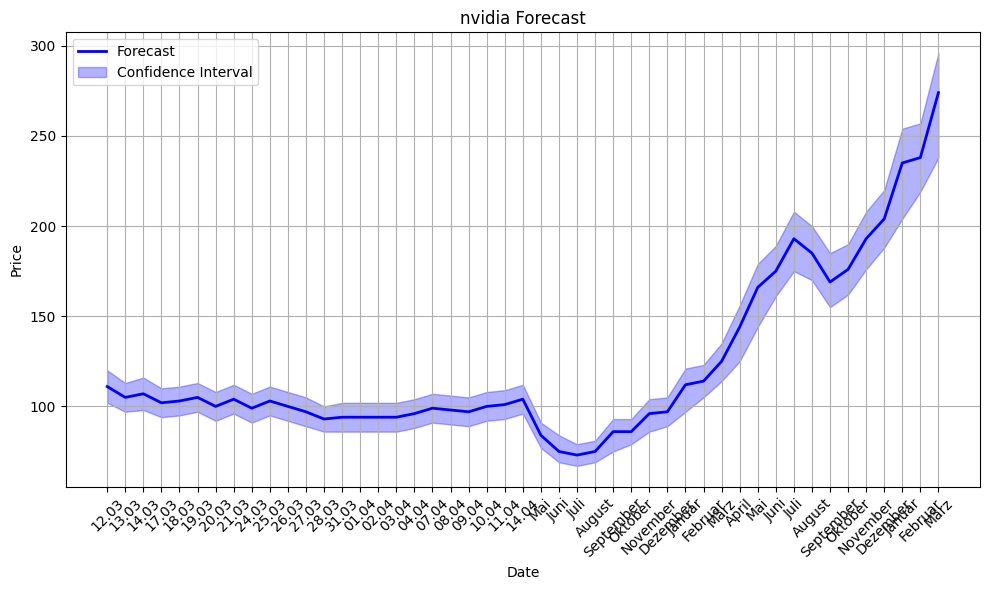

In [6]:
fcg = ForecastGrapper()
fcg.grap_forecast()
fcg.save_forecast()
fcg.plot_forecast()

Forecast data saved to 20250311_rhm-aktie_forecast.csv
Forecast data saved to 20250311_rhm-aktie_forecast.csv


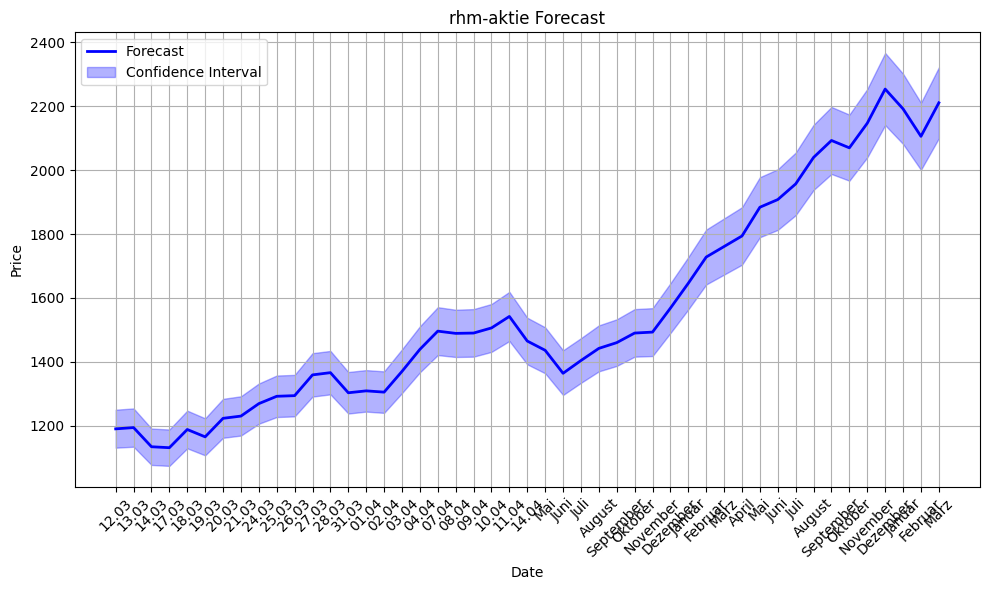

In [7]:
fcg.set_company("rhm-aktie")
fcg.grap_forecast()
fcg.save_forecast()
fcg.plot_forecast()